Validation of the classification based on the WFsim

Buggs in the WFsim that are important to keep in mind:
 -  There is no double photo-emission taken into account
 -  There may be only ~ 500 events before the WFsim crashes
 
 
Possible extensions:
 - Add afterpulse boolian to the 'truth' info
 - Do the same for the other detector types

In [1]:
import strax
import straxen

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed',)).History will not be written to the database.


/home/joran/.conda/envs/strax3.6/lib/python3.6/site-packages/datashader-0.7.0-py3.6.egg/datashader/transfer_functions.py:21: FutureWarning: xarray subclass Image should explicitly define __slots__
  class Image(xr.DataArray):


In [2]:
import wfsim

In [14]:
import numpy as np
import pandas as pd

instruction_dtype = [('event_number', np.int), ('type', '<U2'), ('t', np.int), 
    ('x', np.float32), ('y', np.float32), ('z', np.float32), 
    ('amp', np.int), ('recoil', '<U2')]

def rand_instructions(c):
    n = c['nevents'] = c['event_rate'] * c['chunk_size'] * c['nchunk']
    c['total_time'] = c['chunk_size'] * c['nchunk']

    instructions = np.zeros(2 * n, dtype=instruction_dtype)
    uniform_times = c['total_time'] * (np.arange(n) + 0.5) / n
#     print(uniform_times)
    instructions['t'] = np.repeat(uniform_times, 2) * int(1e9)
    instructions['event_number'] = np.digitize(instructions['t'], 
         1e9 * np.arange(c['nchunk']) * c['chunk_size']) - 1
    instructions['type'] = np.tile(['s1', 's2'], n)
    instructions['recoil'] = ['er' for i in range(n * 2)]

    r = np.sqrt(np.random.uniform(0, 2500, n))
    t = np.random.uniform(-np.pi, np.pi, n)
    instructions['x'] = np.repeat(r * np.cos(t), 2)
    instructions['y'] = np.repeat(r * np.sin(t), 2)
    instructions['z'] = np.repeat(np.random.uniform(-100, 0, n), 2)

    nphotons = np.random.uniform(2000, 2050, n)
    nelectrons = 10 ** (np.random.uniform(1, 4, n))
    instructions['amp'] = np.vstack([nphotons, nelectrons]).T.flatten().astype(int)

    return instructions

c = dict(event_rate = 100, chunk_size=1, nchunk=10)
inst = rand_instructions(c)
_ = pd.DataFrame(inst).to_csv('test_uni.csv', index=False)

In [17]:
!cat test_uni.csv

event_number,type,t,x,y,z,amp,recoil
0,s1,5000000,-20.388397,11.695249,-72.40162,2020,er
0,s2,5000000,-20.388397,11.695249,-72.40162,231,er
0,s1,15000000,4.804671,-9.773261,-18.291079,2047,er
0,s2,15000000,4.804671,-9.773261,-18.291079,26,er
0,s1,25000000,-36.997143,-12.926144,-97.5341,2009,er
0,s2,25000000,-36.997143,-12.926144,-97.5341,327,er
0,s1,35000000,-23.837595,-35.17188,-97.62975,2033,er
0,s2,35000000,-23.837595,-35.17188,-97.62975,3336,er
0,s1,45000000,-11.529277,16.621706,-2.0505536,2000,er
0,s2,45000000,-11.529277,16.621706,-2.0505536,97,er
0,s1,55000000,15.776546,21.178986,-58.836037,2029,er
0,s2,55000000,15.776546,21.178986,-58.836037,297,er
0,s1,65000000,-16.85687,22.016525,-26.861052,2006,er
0,s2,65000000,-16.85687,22.016525,-26.861052,1292,er
0,s1,75000000,-23.714214,32.833035,-54.17991,2028,er
0,s2,75000000,-23.714214,32.833035,-54.17991,95,er
0,s1,85000000,-33.451782,25.564707,-66.52396,2033,er
0,s2,85000000,-33.451782,25.564707,-66.52396,249,er
0,s1,95000000,-28.827

8,s1,8855000000,-32.931675,-6.220962,-85.74494,2005,er
8,s2,8855000000,-32.931675,-6.220962,-85.74494,511,er
8,s1,8865000000,-12.577318,29.314434,-41.07301,2048,er
8,s2,8865000000,-12.577318,29.314434,-41.07301,117,er
8,s1,8875000000,-22.519205,9.129146,-36.502834,2008,er
8,s2,8875000000,-22.519205,9.129146,-36.502834,78,er
8,s1,8885000000,23.933182,-7.303375,-11.841278,2021,er
8,s2,8885000000,23.933182,-7.303375,-11.841278,2785,er
8,s1,8895000000,-4.3101654,-46.471035,-69.05089,2010,er
8,s2,8895000000,-4.3101654,-46.471035,-69.05089,932,er
8,s1,8905000000,-17.97542,35.851936,-84.63961,2044,er
8,s2,8905000000,-17.97542,35.851936,-84.63961,131,er
8,s1,8915000000,-10.369341,-36.993687,-19.000013,2034,er
8,s2,8915000000,-10.369341,-36.993687,-19.000013,65,er
8,s1,8925000000,39.034515,-16.863482,-30.039412,2015,er
8,s2,8925000000,39.034515,-16.863482,-30.039412,267,er
8,s1,8935000000,-35.396847,20.370872,-60.418842,2049,er
8,s2,8935000000,-35.396847,20.370872,-60.418842,185,er
8,s1,8945000

In [45]:
st = strax.Context(
register=[wfsim.RawRecordsFromFax],
config=dict(fax_file='./test_uni.csv'),
**straxen.contexts.common_opts)

In [46]:
# Just some id from post-SR1, so the corrections work
run_id = '180519_1902'

In [47]:
# Call for event_info so it immediately get processed as well
!rm -r strax_data
st.make(run_id, 'event_info')

Simulating Raw Records:  10%|█         | 202/2000 [00:26<03:33,  8.44it/s]

RawRecordsFromFax:140180311841928 waiting for chunk 1


Simulating Raw Records:  20%|██        | 401/2000 [00:54<03:06,  8.57it/s]

RawRecordsFromFax:140180311841928 waiting for chunk 2


Simulating Raw Records:  30%|███       | 601/2000 [01:22<02:34,  9.08it/s]

RawRecordsFromFax:140180311841928 waiting for chunk 3


Simulating Raw Records:  40%|████      | 801/2000 [01:55<02:30,  7.98it/s]

RawRecordsFromFax:140180311841928 waiting for chunk 4


Simulating Raw Records:  50%|█████     | 1001/2000 [02:24<01:40,  9.93it/s]

RawRecordsFromFax:140180311841928 waiting for chunk 5


Simulating Raw Records:  60%|██████    | 1201/2000 [02:51<02:03,  6.46it/s]

RawRecordsFromFax:140180311841928 waiting for chunk 6


Simulating Raw Records:  70%|███████   | 1401/2000 [03:22<01:59,  5.00it/s]

RawRecordsFromFax:140180311841928 waiting for chunk 7


Simulating Raw Records:  80%|████████  | 1601/2000 [03:51<01:05,  6.05it/s]

RawRecordsFromFax:140180311841928 waiting for chunk 8


Simulating Raw Records:  90%|█████████ | 1802/2000 [04:19<00:22,  8.99it/s]

RawRecordsFromFax:140180311841928 waiting for chunk 9


Simulating Raw Records: 100%|██████████| 2000/2000 [04:50<00:00,  6.88it/s]


Source finished!


In [48]:
truth = st.get_df(run_id, 'truth')

data = st.get_df(run_id, 'event_info')

In [49]:
n = c['nevents'] = c['event_rate'] * c['chunk_size'] * c['nchunk']
c['total_time'] = c['chunk_size'] * c['nchunk']
timing_grid = np.linspace(0, c['total_time'], 10*n+1) * 1e9
timing_grid

array([0.000e+00, 1.000e+06, 2.000e+06, ..., 9.998e+09, 9.999e+09,
       1.000e+10])

In [50]:
truth

,event_number,type,t,x,y,z,amp,recoil,n_photon,n_electron,t_first_photon,t_last_photon,t_mean_photon,t_sigma_photon,t_first_electron,t_last_electron,t_mean_electron,t_sigma_electron
0,0,s1,5000000,-20.388397,11.695249,-72.401619,2020,er,277.0,0.0,5.000017e+06,5.000224e+06,5.000072e+06,30.771150,NaN,NaN,NaN,NaN
1,0,s2,5000000,-20.388397,11.695249,-72.401619,231,er,1565.0,72.0,5.541008e+06,5.548552e+06,5.544446e+06,1439.504381,5.540943e+06,5.547796e+06,5.544116e+06,1437.407869
2,0,s1,15000000,4.804671,-9.773261,-18.291079,2047,er,156.0,0.0,1.500001e+07,1.500021e+07,1.500007e+07,30.259627,NaN,NaN,NaN,NaN
3,0,s2,15000000,4.804671,-9.773261,-18.291079,26,er,432.0,21.0,1.513758e+07,1.514014e+07,1.513895e+07,601.798525,1.513738e+07,1.513940e+07,1.513861e+07,590.121162
4,0,s1,25000000,-36.997143,-12.926144,-97.534103,2009,er,330.0,0.0,2.500001e+07,2.500021e+07,2.500007e+07,29.758440,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,9,s2,9975000000,2.390179,9.004135,-46.090645,5049,er,61062.0,2670.0,9.975343e+09,9.975352e+09,9.975347e+09,1067.356891,9.975343e+09,9.975351e+09,9.975347e+09,1054.771673
1996,9,s1,9985000000,-37.746674,-11.734013,-44.766586,2045,er,242.0,0.0,9.985000e+09,9.985000e+09,9.985000e+09,32.923595,NaN,NaN,NaN,NaN
1997,9,s2,9985000000,-37.746674,-11.734013,-44.766586,11,er,87.0,4.0,9.985337e+09,9.985340e+09,9.985339e+09,1089.808375,9.985337e+09,9.985340e+09,9.985338e+09,1058.564945
1998,9,s1,9995000000,-30.629826,11.369081,-32.900448,2020,er,215.0,0.0,9.995000e+09,9.995000e+09,9.995000e+09,31.949270,NaN,NaN,NaN,NaN


In [51]:
truth['merge_index'] = np.digitize(truth['t'], timing_grid)
data['merge_index'] = np.digitize(data['time'], timing_grid)

truth.drop('event_number', axis=1, inplace=True)
data = data.merge(truth[truth['type']=='s2'], how='outer', left_on='merge_index', right_on='merge_index')

In [52]:
data

,event_number,time,endtime,n_peaks,drift_time,s1_index,s1_area,s1_area_fraction_top,s1_range_50p_area,s1_n_competing,...,n_photon,n_electron,t_first_photon,t_last_photon,t_mean_photon,t_sigma_photon,t_first_electron,t_last_electron,t_mean_electron,t_sigma_electron
0,0.0,3999500.0,6548090.0,3.0,540990.0,0.0,234.942398,0.163962,27.363705,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,13999500.0,16139700.0,2.0,137560.0,0.0,132.260147,0.293575,30.877666,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2.0,23999500.0,26736850.0,2.0,728700.0,0.0,245.864029,0.072421,20.822659,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3.0,33999500.0,36738670.0,7.0,727830.0,0.0,249.324463,0.096419,24.471794,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4.0,43999510.0,46018460.0,4.0,16650.0,0.0,165.235199,0.436990,33.169018,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1810.0,93.0,9.955327e+09,9.955334e+09,9.955330e+09,1221.572082,9.955327e+09,9.955333e+09,9.955330e+09,1219.983883
1996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7510.0,378.0,9.965293e+09,9.965298e+09,9.965296e+09,975.613570,9.965292e+09,9.965298e+09,9.965295e+09,966.043140
1997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,61062.0,2670.0,9.975343e+09,9.975352e+09,9.975347e+09,1067.356891,9.975343e+09,9.975351e+09,9.975347e+09,1054.771673
1998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,87.0,4.0,9.985337e+09,9.985340e+09,9.985339e+09,1089.808375,9.985337e+09,9.985340e+09,9.985338e+09,1058.564945


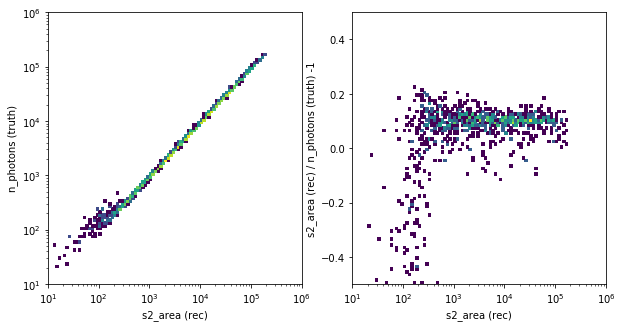

In [39]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from multihist import Histdd, Hist1d

plt.rcParams['figure.figsize'] = (10, 5)
fig = plt.figure()

ax = fig.add_subplot(121)
mh = Histdd(data.s2_area, data.n_photon,
            bins=[np.logspace(1, 6, 101), np.logspace(1, 6, 101)])
plt.pcolormesh(mh.bin_edges[0], mh.bin_edges[1], mh.histogram.T, norm=LogNorm())
plt.xscale('log'); plt.yscale('log')
plt.xlabel('s2_area (rec)'); plt.ylabel('n_photons (truth)')
ax = fig.add_subplot(122)
mh = Histdd(data.n_photon, (data.s2_area-data.n_photon)/data.n_photon, 
            bins=[np.logspace(1, 6, 101), np.linspace(-0.5, 0.5, 101)])
plt.xlabel('s2_area (rec)'); plt.ylabel('s2_area (rec) / n_photons (truth) -1')
plt.pcolormesh(mh.bin_edges[0], mh.bin_edges[1], mh.histogram.T, norm=LogNorm())
plt.xscale('log')

plt.show()

In [40]:
truth = st.get_df(run_id, 'truth')
data = st.get_df(run_id, 'event_info')

truth['merge_index'] = np.digitize(truth['t'], timing_grid)
data['merge_index'] = np.digitize(data['time'], timing_grid)

truth.drop('event_number', axis=1, inplace=True)
data = data.merge(truth[truth['type']=='s1'], how='outer', left_on='merge_index', right_on='merge_index')

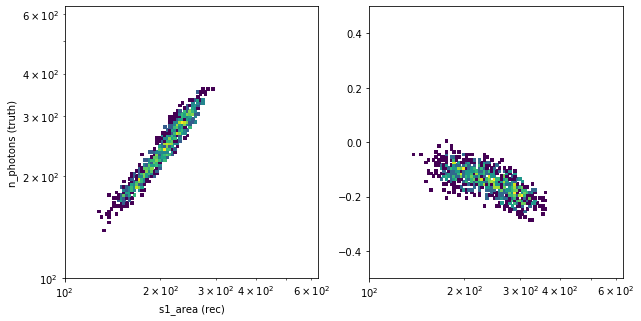

In [42]:
plt.rcParams['figure.figsize'] = (10, 5)
fig = plt.figure()

ax = fig.add_subplot(121)
mh = Histdd(data.s1_area, data.n_photon,
            bins=[np.logspace(2, 2.8, 101), np.logspace(2, 2.8, 101)])
plt.pcolormesh(mh.bin_edges[0], mh.bin_edges[1], mh.histogram.T, norm=LogNorm())
plt.xscale('log'); plt.yscale('log')
plt.xlabel('s1_area (rec)'); plt.ylabel('n_photons (truth)')
ax = fig.add_subplot(122)
mh = Histdd(data.n_photon, (data.s1_area-data.n_photon)/data.n_photon, 
            bins=[np.logspace(2, 2.8, 101), np.linspace(-0.5, 0.5, 101)])
plt.pcolormesh(mh.bin_edges[0], mh.bin_edges[1], mh.histogram.T, norm=LogNorm())
plt.xscale('log')

plt.show()

In [56]:
!rm -r strax_data
peaks = st.make(run_id, 'peak_basics')

Simulating Raw Records:  10%|█         | 201/2000 [00:26<05:07,  5.84it/s]

RawRecordsFromFax:140180019077416 waiting for chunk 1


Simulating Raw Records:  20%|██        | 401/2000 [00:54<03:44,  7.13it/s]

RawRecordsFromFax:140180019077416 waiting for chunk 2


Simulating Raw Records:  30%|███       | 601/2000 [01:23<02:30,  9.30it/s]

RawRecordsFromFax:140180019077416 waiting for chunk 3


Simulating Raw Records:  40%|████      | 801/2000 [01:57<02:21,  8.45it/s]

RawRecordsFromFax:140180019077416 waiting for chunk 4


Simulating Raw Records:  50%|█████     | 1001/2000 [02:29<02:05,  7.95it/s]

RawRecordsFromFax:140180019077416 waiting for chunk 5


Simulating Raw Records:  60%|██████    | 1202/2000 [02:57<02:03,  6.47it/s]

RawRecordsFromFax:140180019077416 waiting for chunk 6


Simulating Raw Records:  70%|███████   | 1401/2000 [03:29<02:18,  4.32it/s]

RawRecordsFromFax:140180019077416 waiting for chunk 7


Simulating Raw Records:  80%|████████  | 1601/2000 [04:00<01:05,  6.12it/s]

RawRecordsFromFax:140180019077416 waiting for chunk 8


Simulating Raw Records:  90%|█████████ | 1802/2000 [04:29<00:25,  7.80it/s]

RawRecordsFromFax:140180019077416 waiting for chunk 9


Simulating Raw Records: 100%|██████████| 2000/2000 [05:02<00:00,  6.61it/s]


Source finished!


In [55]:
peaks

In [57]:
truth = st.get_df(run_id, 'truth')



In [68]:
data = st.get_df(run_id, ['peak_basics','peak_classification'])

In [58]:
!wget https://raw.githubusercontent.com/XENON1T/XeAnalysisScripts/master/PeakFinderTest/recarray_tools.py?token=AFKDK2Q5Y7K3WHOQIBQSRHK5TBRWO

Will not apply HSTS. The HSTS database must be a regular and non-world-writable file.
ERROR: could not open HSTS store at '/home/joran/.wget-hsts'. HSTS will be disabled.
--2019-09-28 11:33:49--  https://raw.githubusercontent.com/XENON1T/XeAnalysisScripts/master/PeakFinderTest/recarray_tools.py?token=AFKDK2Q5Y7K3WHOQIBQSRHK5TBRWO
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.112.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.112.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5287 (5.2K) [text/plain]
Saving to: ‘recarray_tools.py?token=AFKDK2Q5Y7K3WHOQIBQSRHK5TBRWO’

recarray_tools.py?t 100%[===================>]   5.16K  --.-KB/s    in 0s      

2019-09-28 11:33:49 (32.9 MB/s) - ‘recarray_tools.py?token=AFKDK2Q5Y7K3WHOQIBQSRHK5TBRWO’ saved [5287/5287]



In [60]:
data

,time,endtime,area,n_channels,max_pmt,max_pmt_area,range_50p_area,area_fraction_top,length,dt
0,4999490,4999770,220.619858,105,209,6,28.714520,0.089167,28,10
1,5538830,5539290,20.657728,4,145,8,190.239731,0.078087,46,10
2,5540890,5547050,1950.306396,192,106,328,2144.428955,0.668622,154,40
3,14999500,14999750,182.527847,116,188,5,24.360086,0.274164,25,10
4,15137380,15140340,579.042114,141,123,46,840.007874,0.661676,148,20
...,...,...,...,...,...,...,...,...,...,...
5466,9984999480,9984999820,213.266495,125,197,5,29.042696,0.291317,34,10
5467,9985335420,9985335980,13.321349,12,138,2,171.527481,0.084264,56,10
5468,9985336560,9985338550,73.914528,39,59,10,804.994446,0.562254,199,10
5469,9994999500,9994999750,199.867493,115,207,6,31.694618,0.255048,25,10


In [61]:
truth

,event_number,type,t,x,y,z,amp,recoil,n_photon,n_electron,t_first_photon,t_last_photon,t_mean_photon,t_sigma_photon,t_first_electron,t_last_electron,t_mean_electron,t_sigma_electron
0,0,s1,5000000,-20.388397,11.695249,-72.401619,2020,er,275.0,0.0,5.000010e+06,5.000200e+06,5.000071e+06,30.442493,NaN,NaN,NaN,NaN
1,0,s2,5000000,-20.388397,11.695249,-72.401619,231,er,1798.0,82.0,5.539344e+06,5.547511e+06,5.544343e+06,1372.124820,5.539252e+06,5.546726e+06,5.543986e+06,1408.761096
2,0,s1,15000000,4.804671,-9.773261,-18.291079,2047,er,213.0,0.0,1.500002e+07,1.500019e+07,1.500007e+07,29.327106,NaN,NaN,NaN,NaN
3,0,s2,15000000,4.804671,-9.773261,-18.291079,26,er,519.0,20.0,1.513789e+07,1.514079e+07,1.513934e+07,623.797430,1.513782e+07,1.514014e+07,1.513896e+07,598.555808
4,0,s1,25000000,-36.997143,-12.926144,-97.534103,2009,er,300.0,0.0,2.500001e+07,2.500021e+07,2.500007e+07,28.742397,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,9,s2,9975000000,2.390179,9.004135,-46.090645,5049,er,61324.0,2693.0,9.975344e+09,9.975352e+09,9.975347e+09,1077.396965,9.975344e+09,9.975351e+09,9.975347e+09,1064.390194
1996,9,s1,9985000000,-37.746674,-11.734013,-44.766586,2045,er,239.0,0.0,9.985000e+09,9.985000e+09,9.985000e+09,30.310976,NaN,NaN,NaN,NaN
1997,9,s2,9985000000,-37.746674,-11.734013,-44.766586,11,er,79.0,5.0,9.985336e+09,9.985339e+09,9.985338e+09,900.512733,9.985336e+09,9.985338e+09,9.985337e+09,851.166466
1998,9,s1,9995000000,-30.629826,11.369081,-32.900448,2020,er,212.0,0.0,9.995000e+09,9.995000e+09,9.995000e+09,27.635424,NaN,NaN,NaN,NaN


In [69]:
data.dtypes

time                   int64
endtime                int64
area                 float32
n_channels             int16
max_pmt                int16
max_pmt_area           int32
range_50p_area       float32
area_fraction_top    float32
length                 int32
dt                     int16
type                    int8
dtype: object